In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
data=pd.read_csv('../input/train.csv')
data.shape
data.head


['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


<bound method NDFrame.head of                           qid  ...   target
0        00002165364db923c7e6  ...        0
1        000032939017120e6e44  ...        0
2        0000412ca6e4628ce2cf  ...        0
3        000042bf85aa498cd78e  ...        0
4        0000455dfa3e01eae3af  ...        0
5        00004f9a462a357c33be  ...        0
6        00005059a06ee19e11ad  ...        0
7        0000559f875832745e2e  ...        0
8        00005bd3426b2d0c8305  ...        0
9        00006e6928c5df60eacb  ...        0
10       000075f67dd595c3deb5  ...        0
11       000076f3b42776c692de  ...        0
12       000089792b3fc8026741  ...        0
13       000092a90bcfbfe8cd88  ...        0
14       000095680e41a9a6f6e3  ...        0
15       0000a89942e3143e333a  ...        0
16       0000b8e1279eaa0a7062  ...        0
17       0000bc0f62500f55959f  ...        0
18       0000ce6c31f14d3e09ec  ...        0
19       0000d329332845b8a7fa  ...        0
20       0000dd973dfd35508c16  ...        0
21

In [6]:
#data[data['target']==1.head()]
data['target'].value_counts() /data.shape[0]*100

0    93.812982
1     6.187018
Name: target, dtype: float64

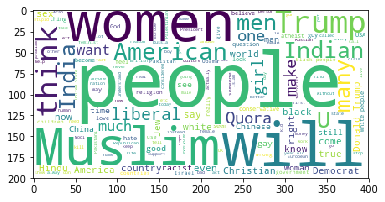

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
insincere_rows=data[data['target']==1]
wc=WordCloud(background_color='white').generate(''.join(insincere_rows['question_text']))
plt.imshow(wc)

In [12]:
from sklearn.model_selection import train_test_split
train, validate=train_test_split(data, test_size=0.3, random_state=1)
train.shape,validate.shape

((914285, 3), (391837, 3))

In [16]:
import nltk

def clean_sentence(doc,stopwords,stemmer):
    words=doc.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)


def clean_documents(docs_raw):
    stopwords=nltk.corpus.stopwords.words('english')
    stemmer= nltk.stem.PorterStemmer()
    docs= docs_raw.str.lower().str.replace('[^a-z ]','')
    docs_clean=docs.apply(lambda doc: clean_sentence(doc, stopwords, stemmer))
    return docs_clean
train_docs_clean = clean_documents(train['question_text'])
train_docs_clean.head()

635414          inhand salari rd prc freshli join mt cil
906079                             one take yolo serious
99492                                  best club nairobi
973656    wake donald trump clock tick  hour return bodi
397612                              made elon musk smart
Name: question_text, dtype: object

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10).fit(train_docs_clean)
dtm=vectorizer.transform(train_docs_clean)

In [20]:
dtm

<914285x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 5406880 stored elements in Compressed Sparse Row format>

In [23]:
from sklearn.tree import DecisionTreeClassifier
model_df = DecisionTreeClassifier(max_depth=10).fit(dtm, train['target'])

In [26]:
validate_docs_clean = clean_documents(validate['question_text'])
dtm_validate = vectorizer.transform(validate_docs_clean)
dtm_validate

<391837x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 2313528 stored elements in Compressed Sparse Row format>

In [29]:
validate_pred=model_df.predict(dtm_validate)
from sklearn.metrics import f1_score
f1_score(validate['target'],validate_pred)

0.2612959489255273

In [28]:
from sklearn.naive_bayes import MultinomialNB
model_nb= MultinomialNB().fit(dtm, train['target'])
validate_pred = model_nb.predict(dtm_validate)
f1_score(validate['target'], validate_pred)

0.5425968470252713

In [31]:
test= pd.read_csv('../input/test.csv')
docs_clean = clean_documents(test['question_text'])
dtm_test = vectorizer.transform(docs_clean)
dtm_test

<375806x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 2220720 stored elements in Compressed Sparse Row format>

In [32]:
test_pred=model_nb.predict(dtm_test)


In [34]:
sample_submission=pd.read_csv('../input/sample_submission.csv')
submission = pd.DataFrame({'qid':test['qid'],
                          'prediction' : test_pred})
submission[['qid','prediction']].to_csv('submission.csv', index=False)